# Dynamax GLM-HMM Fitting Over Sessions

Written by Jess Breda

The goal of this notebook is to assess how to add a dimension of sessions to the E-M fitting used by dynamax.

Specifically, the E step should be fit on a session basis, while the M step should be fit across all sessions.

In looking at the SSM code used by [Zoe](https://github.com/zashwood/ssm/blob/master/notebooks/2b%20Input%20Driven%20Observations%20(GLM-HMM).ipynb) and Daniel, it is hard to determine if they used session boundaries or not. However, they both passed a list of arrays where each item in the list would represent the stimuli (inputs) for a session. [Iris' code](https://github.com/irisstone/glmhmm/blob/860c30d68155401381552e48e19c79bb78b5a0ea/glmhmm/glm_hmm.py#L271) compute the E step separately over each session and then does the M step all together. 





In [1]:
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import LogisticRegressionHMM


from multiglm.utils.dynamax_utils import *
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

### 0 - Initialize True Model

In [2]:
num_states = 2
input_dim = 2
weights = jnp.array([[2.5, -2.5], [-0.5, 0.5]])
baises = jnp.array([0.1, -1])

glmhmm = LogisticRegressionHMM(
    num_states=num_states,
    input_dim=input_dim,
)
params, _ = glmhmm.initialize(
    key=jr.PRNGKey(20), emission_weights=weights, emission_biases=baises
)

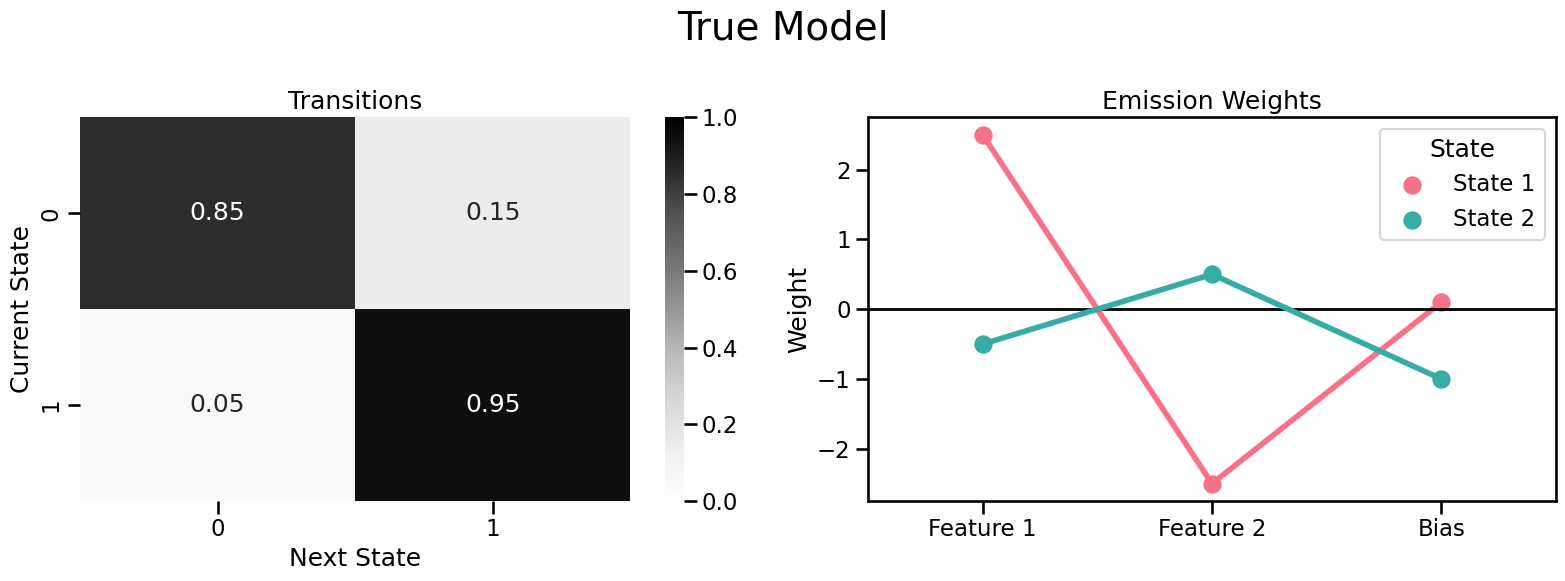

In [3]:
plot_binary_hmm_params(params, plot_bias=True, title="True Model")

### 1- what does Dynamax do with inputs and emissions as a matrix?

Where rows of the matrix indicate a session and columns indicate trials. Here number of trials per session is the same.

#### 1a- Generate Inputs


In [4]:
# Generate inputs
num_trials_per_session = 100
num_sessions = 20
key = jr.PRNGKey(20)
key1, key2 = jr.split(key)
inputs = jr.normal(key1, shape=(num_sessions, num_trials_per_session, input_dim))

print("first 5 inputs session 1: \n", inputs[0, :5])
print("\nfirst 5 inputs session 2: \n", inputs[1, :5])

print("first 5 inputs session 1: \n", inputs[0, :5])
print("\nfirst 5 inputs session 2: \n", inputs[1, :5])

first 5 inputs session 1: 
 [[ 0.11166067  0.6614149 ]
 [ 1.5773239  -0.42039394]
 [-0.26032954 -0.54903895]
 [ 0.18120782  0.6655163 ]
 [ 1.2096097  -0.7752653 ]]

first 5 inputs session 2: 
 [[ 1.8686095   0.42686242]
 [ 0.6554103   0.0742984 ]
 [-1.2095069  -0.9076591 ]
 [ 0.01817281  0.75667363]
 [-0.48795763  0.49700797]]
first 5 inputs session 1: 
 [[ 0.11166067  0.6614149 ]
 [ 1.5773239  -0.42039394]
 [-0.26032954 -0.54903895]
 [ 0.18120782  0.6655163 ]
 [ 1.2096097  -0.7752653 ]]

first 5 inputs session 2: 
 [[ 1.8686095   0.42686242]
 [ 0.6554103   0.0742984 ]
 [-1.2095069  -0.9076591 ]
 [ 0.01817281  0.75667363]
 [-0.48795763  0.49700797]]


#### 1b- Sample states and emissions from true model

Since the number of trials per session is stable here, it would be possible to use vmap. However, this isn't feasible once the trials change (and they will in the real data), so I am implementing it here with this future prospect in mind. Specifically, by iterating over the sessions and sampling from each. 

This code is similar to what Zoe did in her demo notebook in [section 2d](https://github.com/zashwood/ssm/blob/master/notebooks/2b%20Input%20Driven%20Observations%20(GLM-HMM).ipynb).

In [5]:
true_states = []
emissions = []

for session_input in inputs:
    true_z, true_y = glmhmm.sample(
        params,
        key2,
        num_timesteps=num_trials_per_session,
        inputs=session_input,
    )
    true_states.append(true_z)
    emissions.append(true_y)

# Convert lists to JAX arrays
true_states_flat = jnp.concatenate(true_states)
emissions_flat = jnp.concatenate(emissions)

emissions_jnp = jnp.array(emissions)
emissions_expanded = jnp.expand_dims(emissions_jnp, axis=-1)

However unlike Zoe, it appears I am unable to pass flattened emissions without also flattening the inputs (hence the reshape).

I also tried sessions x num time step emissions with sessions x num time step x num features inputs and that did not work. The error was due to time steps (100) and features (2) not properly matching. The same error persisted when I packed the emissions array to be (20, 100, 1).  

> TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (100,).


In [6]:
true_ll = glmhmm.marginal_log_prob(
    params, emissions_flat, jnp.reshape(inputs, (-1, input_dim))
)
print(f"True log likelihood: {true_ll:.2f}")

True log likelihood: -1160.12


#### 1c- fit glm-hmm

In [7]:
glmhmm_to_fit = LogisticRegressionHMM(
    num_states=num_states,
    input_dim=input_dim,
)
em_params, em_param_props = glmhmm_to_fit.initialize(
    key,
)

In [8]:
em_params, log_probs = glmhmm_to_fit.fit_em(
    em_params,
    em_param_props,
    emissions=emissions_jnp,
    inputs=inputs,
    num_iters=100,
)

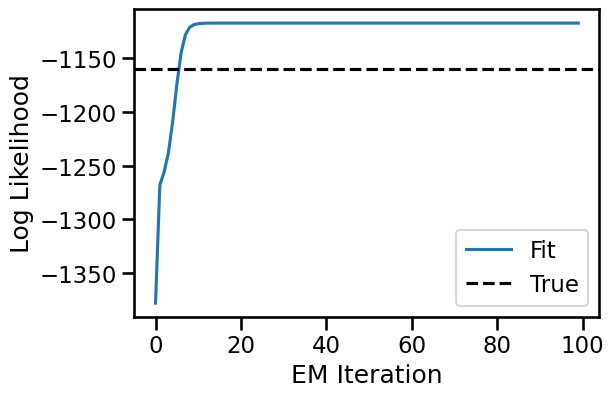

In [9]:
plot_ll_over_iters_recovery(log_probs, glmhmm_to_fit.log_prior(em_params), true_ll)

Okay great- this appears to have worked because the model interpreted there to be a "batch dimension". However, the E step and the M step were run on each batch separately as defined by the em_step in SSM. 

My concern is that this code will break as soon as the number of trials per session starts to vary.

Lets see if we can access the e_step on it's own

In [10]:
glmhmm_to_fit = LogisticRegressionHMM(
    num_states=num_states,
    input_dim=input_dim,
)
em_params, em_param_props = glmhmm_to_fit.initialize(
    key,
)

Now, lets take an estep for a single session and see what is returned

In [11]:
session_num = 0
log_probs = []
stats, lls = glmhmm_to_fit.e_step(
    em_params, emissions_jnp[session_num, :], inputs[session_num, :]
)

lp = glmhmm_to_fit.log_prior(em_params) + lls.sum()

lls is the log likelihood. stats is a dynamax object of type SuffStatsSSM. which is a named tupe with the parameters needed to be learned. Here this would be the initial state probabilities, transtion matrix and emission weights (possibly just the inputs repeated n_features times?)

In [12]:
lls

Array(-69.06373, dtype=float32)

In [13]:
em_params.initial.probs

Array([0.6923416, 0.3076584], dtype=float32)

In [14]:
stats

(Array([0.5115763, 0.4884237], dtype=float32),
 Array([[ 9.772851 ,  3.0648139],
        [ 2.7271779, 83.43517  ]], dtype=float32),
 (Array([[0.5115763 , 0.4884237 ],
         [0.46066308, 0.5393369 ],
         [0.35666856, 0.64333147],
         [0.17976502, 0.82023495],
         [0.11029623, 0.88970375],
         [0.09098496, 0.90901506],
         [0.10404112, 0.89595884],
         [0.16311261, 0.83688736],
         [0.17679614, 0.82320386],
         [0.14744434, 0.85255563],
         [0.06818034, 0.9318196 ],
         [0.03541854, 0.9645815 ],
         [0.02192178, 0.97807825],
         [0.01616706, 0.98383296],
         [0.01411397, 0.98588604],
         [0.01306436, 0.9869356 ],
         [0.01284056, 0.98715943],
         [0.01282391, 0.98717606],
         [0.0130884 , 0.9869116 ],
         [0.01460885, 0.98539114],
         [0.01763712, 0.98236287],
         [0.02438886, 0.9756111 ],
         [0.0411613 , 0.9588387 ],
         [0.02475685, 0.9752431 ],
         [0.01869402, 0.9813

Based on investigations below, the third object in stats is:

a list of the probabilities for each trial stats[2][0]
states for each trial stats[2][1] given the probabilities
actual raw input data stats[2][2]

In [15]:
len(stats[2])

3

In [16]:
stats[2][0].shape, stats[2][0]

((100, 2),
 Array([[0.5115763 , 0.4884237 ],
        [0.46066308, 0.5393369 ],
        [0.35666856, 0.64333147],
        [0.17976502, 0.82023495],
        [0.11029623, 0.88970375],
        [0.09098496, 0.90901506],
        [0.10404112, 0.89595884],
        [0.16311261, 0.83688736],
        [0.17679614, 0.82320386],
        [0.14744434, 0.85255563],
        [0.06818034, 0.9318196 ],
        [0.03541854, 0.9645815 ],
        [0.02192178, 0.97807825],
        [0.01616706, 0.98383296],
        [0.01411397, 0.98588604],
        [0.01306436, 0.9869356 ],
        [0.01284056, 0.98715943],
        [0.01282391, 0.98717606],
        [0.0130884 , 0.9869116 ],
        [0.01460885, 0.98539114],
        [0.01763712, 0.98236287],
        [0.02438886, 0.9756111 ],
        [0.0411613 , 0.9588387 ],
        [0.02475685, 0.9752431 ],
        [0.01869402, 0.98130596],
        [0.01786696, 0.9821331 ],
        [0.02114723, 0.97885275],
        [0.03097752, 0.9690225 ],
        [0.05574916, 0.9442508 ],
   

In [17]:
stats[2][1]  # these are the emissions

Array([0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1], dtype=int32)

In [18]:
stats[2][0][0:5], stats[2][2][0:5], inputs[session_num, :5]

(Array([[0.5115763 , 0.4884237 ],
        [0.46066308, 0.5393369 ],
        [0.35666856, 0.64333147],
        [0.17976502, 0.82023495],
        [0.11029623, 0.88970375]], dtype=float32),
 Array([[ 0.11166067,  0.6614149 ],
        [ 1.5773239 , -0.42039394],
        [-0.26032954, -0.54903895],
        [ 0.18120782,  0.6655163 ],
        [ 1.2096097 , -0.7752653 ]], dtype=float32),
 Array([[ 0.11166067,  0.6614149 ],
        [ 1.5773239 , -0.42039394],
        [-0.26032954, -0.54903895],
        [ 0.18120782,  0.6655163 ],
        [ 1.2096097 , -0.7752653 ]], dtype=float32))

Lets see how the results change from session to session

In [19]:
session_num = 1
log_probs = []
stats2, lls2 = glmhmm_to_fit.e_step(
    em_params, emissions_jnp[session_num, :], inputs[session_num, :]
)

lp2 = glmhmm_to_fit.log_prior(em_params) + lls2.sum()

In [20]:
lp, lp2

(Array(-146.49496, dtype=float32), Array(-145.94841, dtype=float32))

In [21]:
stats[0], stats2[0]  # state probabilities do appear to change

(Array([0.5115763, 0.4884237], dtype=float32),
 Array([0.784584  , 0.21541603], dtype=float32))

In [22]:
stats[1], stats[1]  # transition matrix doesn't appear to change

(Array([[ 9.772851 ,  3.0648139],
        [ 2.7271779, 83.43517  ]], dtype=float32),
 Array([[ 9.772851 ,  3.0648139],
        [ 2.7271779, 83.43517  ]], dtype=float32))

In [23]:
stats[2][0][0:5], stats2[2][0][0:5]

(Array([[0.5115763 , 0.4884237 ],
        [0.46066308, 0.5393369 ],
        [0.35666856, 0.64333147],
        [0.17976502, 0.82023495],
        [0.11029623, 0.88970375]], dtype=float32),
 Array([[0.784584  , 0.21541603],
        [0.675302  , 0.3246979 ],
        [0.50467914, 0.49532083],
        [0.24116732, 0.7588327 ],
        [0.13440226, 0.8655977 ]], dtype=float32))

In [24]:
stats[2][1][0:5], stats2[2][1][0:5]

(Array([0, 1, 1, 0, 0], dtype=int32), Array([1, 1, 1, 0, 0], dtype=int32))

In [25]:
stats[2][2][0:5], stats2[2][2][0:5]

(Array([[ 0.11166067,  0.6614149 ],
        [ 1.5773239 , -0.42039394],
        [-0.26032954, -0.54903895],
        [ 0.18120782,  0.6655163 ],
        [ 1.2096097 , -0.7752653 ]], dtype=float32),
 Array([[ 1.8686095 ,  0.42686242],
        [ 0.6554103 ,  0.0742984 ],
        [-1.2095069 , -0.9076591 ],
        [ 0.01817281,  0.75667363],
        [-0.48795763,  0.49700797]], dtype=float32))

Okay so as expected the calculations to change from session to session because they are being fit on different data. A this point is unclear to me how these data could be summarized such that a single M-step could be used.

### 2- what does Dynamax do with inputs and emissions as a lists of lists?

Where the length of the list indicates the number of sessions and the length of each sub-list is number of trials in a session

#### 2a- Generate Inputs


In [27]:
# Define parameters
num_sessions = 20
input_dim = 2  # Example input dimension, you can change it accordingly

# Initialize random key
key = jr.PRNGKey(20)

# Generate random number of trials per session between 0 and 100
trial_counts = jr.randint(key, shape=(num_sessions,), minval=0, maxval=100)

# Generate the inputs as a list of JAX arrays with variable lengths
inputs = []
for trial_count in trial_counts:
    key, subkey = jr.split(key)
    session_data = jr.normal(subkey, shape=(trial_count, input_dim))
    inputs.append(session_data)

In [28]:
len(inputs[0]), len(inputs[1])

(68, 10)

#### 2b- Sample states and emissions from true model


In [29]:
true_states = []
emissions = []

for session_input in inputs:
    true_z, true_y = glmhmm.sample(
        params,
        key2,
        num_timesteps=len(session_input),
        inputs=session_input,
    )
    true_states.append(true_z)
    emissions.append(true_y)

# Convert lists to JAX arrays
true_states_flat = jnp.concatenate(true_states)
emissions_flat = jnp.concatenate(emissions)

In [30]:
true_ll = glmhmm.marginal_log_prob(
    params, emissions_flat, jnp.concatenate(inputs, axis=0)
)
print(f"True log likelihood: {true_ll:.2f}")

True log likelihood: -560.93


#### 2c- fit glm-hmm

In [46]:
glmhmm_to_fit = LogisticRegressionHMM(
    num_states=num_states,
    input_dim=input_dim,
)
em_params, em_param_props = glmhmm_to_fit.initialize(
    key,
)

It does not appear that the code is able to handle a list with mismatched array sizes due to the adding batch dimensions call that assumes that the inputs are a jax array.

GPT chat to determine how to adjust the code such that list of lists got a batch dimension [link](https://chat.openai.com/share/b7cb6284-9fcc-4212-a8cc-131db89998d2). Specifically, because inputs was a list, the input dims also needed to be a list.

In [68]:
from dynamax.utils.utils import *

instance_shapes = [(2,)] * len(inputs)

batch_inputs = ensure_array_has_batch_dim(inputs, (2,))

In [71]:
em_params, log_probs = glmhmm_to_fit.fit_em(
    em_params,
    em_param_props,
    emissions=emissions_flat,
    inputs=inputs,
    num_iters=100,
)

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 47, e.g. axis 0 of argument inpt[2] of type float32[47,2];
  * some axes (2 of them) had size 85, e.g. axis 0 of argument inpt[8] of type float32[85,2];
  * one axis had size 945: axis 0 of argument emission of type int32[945];
  * one axis had size 68: axis 0 of argument inpt[0] of type float32[68,2];
  * one axis had size 10: axis 0 of argument inpt[1] of type float32[10,2];
  * one axis had size 73: axis 0 of argument inpt[4] of type float32[73,2];
  * one axis had size 60: axis 0 of argument inpt[5] of type float32[60,2];
  * one axis had size 75: axis 0 of argument inpt[6] of type float32[75,2];
  * one axis had size 46: axis 0 of argument inpt[7] of type float32[46,2];
  * one axis had size 4: axis 0 of argument inpt[9] of type float32[4,2];
  * one axis had size 23: axis 0 of argument inpt[10] of type float32[23,2];
  * one axis had size 21: axis 0 of argument inpt[11] of type float32[21,2];
  * one axis had size 17: axis 0 of argument inpt[12] of type float32[17,2];
  * one axis had size 61: axis 0 of argument inpt[13] of type float32[61,2];
  * one axis had size 15: axis 0 of argument inpt[15] of type float32[15,2];
  * one axis had size 1: axis 0 of argument inpt[16] of type float32[1,2];
  * one axis had size 96: axis 0 of argument inpt[17] of type float32[96,2];
  * one axis had size 27: axis 0 of argument inpt[18] of type float32[27,2];
  * one axis had size 84: axis 0 of argument inpt[19] of type float32[84,2]

Next steps:

> how doe these calculations change from session to session. In other words, is there anyway to iterate over the E-step for each session and then pass some sort of summary into the M-step

> what does m_step return?

> test with a list of lists and see what breaks?

> write an issue on git asking about this
